# Overview

This notebook demonstrates how to learn a neural network model of drone dynamics from data. Rather than relying on first-principles physics models, we train an ANN to predict state derivatives (accelerations, angular accelerations) from current states and control inputs.

**Topics covered:**

1. **Install and Import Packages** - Setup the computational environment
2. **Load and Prepare Training Data** - Import trajectory data and add realistic noise
3. **Compute State Derivatives** - Calculate time derivatives of state variables
4. **Data Augmentation with Delay Embedding** - Create time-windowed inputs for hysteresis
5. **Neural Network Training** - Build and train the dynamics model
6. **Model Evaluation** - Visualize performance and validate predictions
7. **Exercises** - Exercises to explore the performance and training parameters of your model

**Key learning objectives:**
- Understand how to learn continuous-time dynamics models from data
- Build neural networks with auxiliary delay-embedded inputs and costs on the Jacobian
- Evaluate dynamics model accuracy on test trajectories

# 1.&nbsp;Install and Import Packages

## Install utility

In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:

try:
    import nonlinear_estimation_utilities
    print('Package ' + 'nonlinear_estimation_utilities' + ' is already installed.')
    nonlinear_estimation_utilities.check_for_updates()
except:
    !pip install -qq git+https://github.com/florisvb/Nonlinear_and_Data_Driven_Estimation && echo "✓ nonlinear_estimation_utilities installed"
    import nonlinear_estimation_utilities
    nonlinear_estimation_utilities.check_for_updates()

  Preparing metadata (setup.py) ... done
✓ nonlinear_estimation_utilities installed
✓ You have the latest version (0.0.35)


## Install requirements

In [3]:
nonlinear_estimation_utilities.install_and_download_requirements.install_planar_drone_requirements()
nonlinear_estimation_utilities.install_and_download_requirements.install_neural_network_requirements()

Attempting to pip install: casadi
Attempting to pip install: do_mpc
Attempting to pip install: git+https://github.com/vanbreugel-lab/pybounds
Attempting to pip install: pynumdiff
Already installed: tensorflow
Already installed: keras
Attempting to pip install: keras-visualizer
✓ pynumdiff 0.2 meets requirement >=0.1.4
Already installed: pynumdiff


## Install modules

In [4]:
nonlinear_estimation_utilities.load_planar_drone_modules()
nonlinear_estimation_utilities.load_neural_network_modules()

## Import modules

In [5]:
import copy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

In [41]:
import keras
import tensorflow as tf

In [7]:
import pynumdiff

In [8]:
from nonlinear_estimation_utilities import plot_utility
from nonlinear_estimation_utilities import planar_drone
from nonlinear_estimation_utilities import generate_training_data_utility
from nonlinear_estimation_utilities import terrain_and_optic_flow_utility
from nonlinear_estimation_utilities import keras_ann_utility
from nonlinear_estimation_utilities import keras_advanced_utility

from nonlinear_estimation_utilities.plot_utility import plot_tme

# 2.&nbsp;Load and Prepare Training Data

We'll download trajectory data from simulations of the planar drone, then clean and add measurement noise to create realistic training conditions. This follows the same preprocessing pipeline as Lesson 12.A.

## Download trajectory data

Download the pre-generated trajectory dataset.

In [11]:
generate_training_data_utility.download_data('planar_drone_trajectories.zip')

Fetching from: https://raw.githubusercontent.com/florisvb/Nonlinear_and_Data_Driven_Estimation/main/Data/planar_drone_trajectories.zip
Successfully downloaded planar_drone_trajectories.zip (29316396 bytes)
unzipping...


## Load and clean trajectories

Load the trajectory data and remove any corrupted or invalid trajectories.

In [12]:
traj_list = generate_training_data_utility.load_trajectory_data('planar_drone_trajectories')

Number of trajectories: 
3001


In [13]:
traj_list = generate_training_data_utility.clean_trajectory_data(traj_list)

Number of good trajectories: 
2924


## Add measurement noise

Add realistic Gaussian noise to state measurements to simulate sensor uncertainty. This ensures the learned model is robust to measurement noise.

In [14]:
traj_list = generate_training_data_utility.add_noise_to_trajectory_data(traj_list, 0.02)

# 3.&nbsp;Compute State Derivatives

To train a dynamics model that predicts $\dot{\mathbf{x}} = \mathbf{f}(\mathbf{x}, \mathbf{u})$, we need to compute the time derivatives of the state variables from the trajectory data. We use numerical differentiation methods that are robust to measurement noise.

The derivatives become the **output targets** for our neural network:
- **Inputs:** Current state $\mathbf{x}$ and control $\mathbf{u}$
- **Outputs:** State derivatives $\dot{\mathbf{x}}$ (rates of change)

For the planar drone, the state vector includes: $[\theta, \dot{\theta}, x, \dot{x}, z, \dot{z}]$.

We compute numerical derivatives for all state variables using noise-robust differentiation methods.

In [15]:
state_names =  ['theta', 'theta_dot', 'x', 'x_dot', 'z', 'z_dot']

In [16]:
for i, traj in enumerate(traj_list):
    for state in state_names:
        state_smooth, ddt_state = pynumdiff.savgoldiff(traj[state], 0.1, degree=3, window_size=5, smoothing_win=5)
        traj['ddt_' + state] = ddt_state
    traj_list[i] = traj

# 4.&nbsp;Data Augmentation with Delay Embedding

This section shows how to include auxiliary time delay embedding in the neural network inputs. If your dynamics are truly Markovian and given by:

$$
\dot{\mathbf{x}} = \mathbf{f}(\mathbf{x}, \mathbf{u})
$$

then delay embedding is unnecessary. However, if your dynamics contain **hysteresis** (dependence on past states), **unmodeled delays**, or **measurement artifacts**, you may need this functionality to capture the true system behavior.

**Benefits of delay embedding:**
- Captures non-Markovian dynamics and hysteresis effects
- Provides temporal context for prediction
- Can compensate for measurement delays or filtering effects
- Improves robustness to noisy or incomplete state information

**Downsides of delay embedding:**
- When deployed in the Kalman filter can lead to unexpected behavior when the initial state guess is incorrect

Here we will use an architecture that supports the delay embedding, but will train the network with a high level of dropout so that the network does not relay on the delayed information, allowing us to ignore that portion of the architecture.

## Define augmentation parameters

Specify which variables to include and the time offsets for delay embedding.

In [17]:
state_names =  ['theta', 'theta_dot', 'x', 'x_dot', 'z', 'z_dot']
control_names = ['j1', 'j2']
output_names = ['ddt_' + state for state in state_names] #'theta', 'theta_dot', 'x', 'x_dot', 'z', 'z_dot']

In [18]:
state_offsets = [0, -1]
control_offsets = [0, -1]
output_offsets = [0]

In [19]:
trim_edges = 4 # drop the first and last of these frames to remove bad derivatives and artifacts

## Build augmented dataframes

Create augmented trajectories where each row contains both current and past values of states and controls.

In [20]:
traj_augment_list = []
for traj in traj_list:
    traj_augment = keras_ann_utility.collect_offset_rows(traj[trim_edges:-1*trim_edges],
                                                         states=state_names,
                                                         controls=control_names,
                                                         outputs=output_names,
                                                         state_offsets=state_offsets,
                                                         control_offsets=control_offsets,
                                                         output_offsets=output_offsets)
    traj_augment_list.append(traj_augment)

# merge all trajectories
traj_augment_all = pd.concat(traj_augment_list, ignore_index=True)

# show the data frame so you can confirm it looks right
np.round(traj_augment_all, 4)

,theta_offset_0,theta_dot_offset_0,x_offset_0,x_dot_offset_0,z_offset_0,z_dot_offset_0,theta_offset_-1,theta_dot_offset_-1,x_offset_-1,x_dot_offset_-1,...,j1_offset_0,j2_offset_0,j1_offset_-1,j2_offset_-1,ddt_theta_offset_0,ddt_theta_dot_offset_0,ddt_x_offset_0,ddt_x_dot_offset_0,ddt_z_offset_0,ddt_z_dot_offset_0
0,-0.7946,-0.0152,-7.8118,9.9408,8.2482,-0.9439,-0.8145,-0.0273,-8.7059,7.4109,...,1.1344,36.1223,-0.0243,35.6977,1.0054,16.1624,9.9152,24.0517,-1.0079,16.3714
1,-0.6711,2.8177,-6.7269,12.3465,8.2036,0.7255,-0.7946,-0.0152,-7.8118,9.9408,...,1.8062,34.7808,1.1344,36.1223,3.3301,29.4463,12.0880,17.7956,0.7581,19.1915
2,-0.1406,7.2608,-5.3673,13.7751,8.3843,2.8989,-0.6711,2.8177,-6.7269,12.3465,...,-0.7891,32.6586,1.8062,34.7808,5.3174,8.7917,13.1731,3.7714,2.8633,20.6109
3,0.5080,5.3402,-4.0451,13.1322,8.7854,5.0370,-0.1406,7.2608,-5.3673,13.7751,...,-1.9897,29.9469,-0.7891,32.6586,4.3342,-25.8014,12.7535,-10.8491,4.8242,17.2024
4,0.7767,0.3967,-2.8060,11.3224,9.3557,6.3850,0.5080,5.3402,-4.0451,13.1322,...,-0.2472,26.2909,-1.9897,29.9469,1.6889,-25.2318,11.4749,-17.5347,6.3520,11.5947
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236839,-0.1920,1.0147,0.3371,0.6697,3.2803,-3.1814,-0.2632,0.2630,0.2646,0.4823,...,0.0815,10.0992,0.3437,8.0044,0.8237,4.5516,0.7356,1.4722,-3.2615,-0.7932
236840,-0.0734,1.1677,0.4189,0.7822,2.9099,-3.1732,-0.1920,1.0147,0.3371,0.6697,...,-0.0904,12.1831,0.0815,10.0992,0.8603,-0.8043,0.8013,1.0681,-3.2762,1.2512
236841,-0.0193,0.7888,0.4995,0.8874,2.6032,-2.9348,-0.0734,1.1677,0.4189,0.7822,...,-0.1905,14.0841,-0.0904,12.1831,0.6681,-3.8515,0.7696,0.3779,-2.7658,3.2328
236842,0.0539,0.3178,0.5708,0.8706,2.3626,-2.5116,-0.0193,0.7888,0.4995,0.8874,...,-0.1471,15.7707,-0.1905,14.0841,0.4059,-3.9495,0.7693,-0.6057,-2.2875,4.8817


In [21]:
n_state = len(state_names)
n_control = len(control_names)
n_output = len(output_names)
delay_embedding = len(state_offsets)

print('States:', n_state)
print('Controls:', n_control)
print('Outputs:', n_output)
print('Delay embedding:', delay_embedding)

States: 6
Controls: 2
Outputs: 6
Delay embedding: 2


## Separate inputs, controls, and outputs

Split the augmented data into:
- **State inputs** (core and auxiliary/delayed)
- **Control inputs** (core and auxiliary/delayed)
- **Output targets** (state derivatives)

In [22]:
# Augmented state data
X = traj_augment_all.iloc[:, 0:n_state*delay_embedding]
X

,theta_offset_0,theta_dot_offset_0,x_offset_0,x_dot_offset_0,z_offset_0,z_dot_offset_0,theta_offset_-1,theta_dot_offset_-1,x_offset_-1,x_dot_offset_-1,z_offset_-1,z_dot_offset_-1
0,-0.794623,-0.015188,-7.811755,9.940811,8.248227,-0.943912,-0.814545,-0.027322,-8.705893,7.410925,8.412118,-2.476371
1,-0.671092,2.817722,-6.726893,12.346453,8.203576,0.725470,-0.794623,-0.015188,-7.811755,9.940811,8.248227,-0.943912
2,-0.140587,7.260762,-5.367277,13.775110,8.384302,2.898867,-0.671092,2.817722,-6.726893,12.346453,8.203576,0.725470
3,0.508025,5.340191,-4.045092,13.132176,8.785398,5.036958,-0.140587,7.260762,-5.367277,13.775110,8.384302,2.898867
4,0.776692,0.396677,-2.805982,11.322366,9.355704,6.385029,0.508025,5.340191,-4.045092,13.132176,8.785398,5.036958
...,...,...,...,...,...,...,...,...,...,...,...,...
236839,-0.192041,1.014685,0.337128,0.669725,3.280252,-3.181417,-0.263182,0.262993,0.264584,0.482346,3.570626,-3.014521
236840,-0.073402,1.167660,0.418853,0.782201,2.909858,-3.173196,-0.192041,1.014685,0.337128,0.669725,3.280252,-3.181417
236841,-0.019347,0.788767,0.499483,0.887388,2.603207,-2.934834,-0.073402,1.167660,0.418853,0.782201,2.909858,-3.173196
236842,0.053938,0.317787,0.570753,0.870552,2.362568,-2.511649,-0.019347,0.788767,0.499483,0.887388,2.603207,-2.934834


In [23]:
# Augmented control data
U = traj_augment_all.iloc[:, n_state*delay_embedding:n_state*delay_embedding+n_control*delay_embedding]
U

,j1_offset_0,j2_offset_0,j1_offset_-1,j2_offset_-1
0,1.134393,36.122348,-0.024267,35.697670
1,1.806164,34.780770,1.134393,36.122348
2,-0.789103,32.658625,1.806164,34.780770
3,-1.989741,29.946894,-0.789103,32.658625
4,-0.247164,26.290901,-1.989741,29.946894
...,...,...,...,...
236839,0.081516,10.099191,0.343707,8.004384
236840,-0.090373,12.183127,0.081516,10.099191
236841,-0.190512,14.084072,-0.090373,12.183127
236842,-0.147143,15.770710,-0.190512,14.084072


In [24]:
# Output data
Y = traj_augment_all.iloc[:, n_state*delay_embedding+n_control*delay_embedding:]
Y

,ddt_theta_offset_0,ddt_theta_dot_offset_0,ddt_x_offset_0,ddt_x_dot_offset_0,ddt_z_offset_0,ddt_z_dot_offset_0
0,1.005383,16.162354,9.915190,24.051747,-1.007901,16.371431
1,3.330127,29.446299,12.088049,17.795607,0.758102,19.191519
2,5.317424,8.791658,13.173071,3.771400,2.863315,20.610878
3,4.334211,-25.801374,12.753517,-10.849071,4.824244,17.202389
4,1.688858,-25.231778,11.474912,-17.534682,6.351974,11.594723
...,...,...,...,...,...,...
236839,0.823749,4.551606,0.735588,1.472202,-3.261538,-0.793164
236840,0.860320,-0.804263,0.801296,1.068100,-3.276223,1.251163
236841,0.668105,-3.851545,0.769584,0.377873,-2.765799,3.232753
236842,0.405949,-3.949482,0.769256,-0.605660,-2.287538,4.881740


## Organize the data

Package the data into a structured format with core inputs (current time) and auxiliary inputs (time-delayed) for the neural network.

In [25]:
# Organize the data so we have the core data, and augmented (delay embedded) data
core_data = np.hstack((X.values[:, 0:n_state], U.values[:, 0:n_control]))
aux_data = np.hstack((X.values[:, n_state:], U.values[:, n_control:]))
output_data = Y.values

In [26]:
all_data = {'X_core_train': core_data,
        'X_aux_train': aux_data,
        'y_train': output_data}

## Split into training and validation sets

Divide the data into training, validation, and test subsets to evaluate generalization performance.

In [27]:
# split the data
data = keras_advanced_utility.prepare_train_test_split(all_data, test_size=0.2, random_state=42)

Data split complete:
  Training samples: 189475 (80%)
  Test samples: 47369 (20%)
  Core features: 8
  Aux features: 8
  Output dimension: 6


In [28]:
data.keys()

dict_keys(['X_core_train', 'X_core_test', 'X_aux_train', 'X_aux_test', 'y_train', 'y_test'])

# 5.&nbsp;Neural Network Training

We'll build a neural network with a specialized architecture for dynamics modeling:

**Architecture components:**
- **Core input branch:** Processes current state and control
- **Auxiliary input branch:** Processes time-delayed state and control history
- **Combined layers:** Merges both branches to predict state derivatives
- **Output layer:** Predicts all state derivatives simultaneously

The network is trained to minimize prediction error of the state derivatives, with optional Jacobian regularization to ensure smooth dynamics predictions.

## Define architecture of the model

Specify the network architecture with separate processing paths for core and auxiliary inputs, then build, and compile it.

In [29]:
# Define model architecture
core_architecture = [
    {'units': 64, 'activation': 'tanh'},
    {'units': 64, 'activation': 'tanh'}
]

aux_architecture = [
    {'units': 64, 'activation': 'tanh'}
]

combined_architecture = [
    {'units': 32, 'activation': 'linear'},
    {'units': output_data.shape[1]}  # Output layer
]

input_architecture = {'core_input_dim': data['X_core_train'].shape[1],
                      'aux_input_dim': data['X_aux_train'].shape[1]}


training_parameters = {'jacobian_weight': 1.0,
                       'sv_weight': 0.01}

In [30]:
# Build model
print("\nBuilding model...")
model, dropout_layer = keras_advanced_utility.build_auxiliary_dropout_model(
    core_input_dim=input_architecture['core_input_dim'],
    aux_input_dim=input_architecture['aux_input_dim'],
    core_architecture=core_architecture,
    aux_architecture=aux_architecture,
    combined_architecture=combined_architecture,
    jacobian_weight=training_parameters['jacobian_weight'],
    sv_weight=training_parameters['sv_weight']
)


Building model...


In [42]:
# Compile model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss='mse',
    metrics=['mae']
)

## Visualize the model architecture

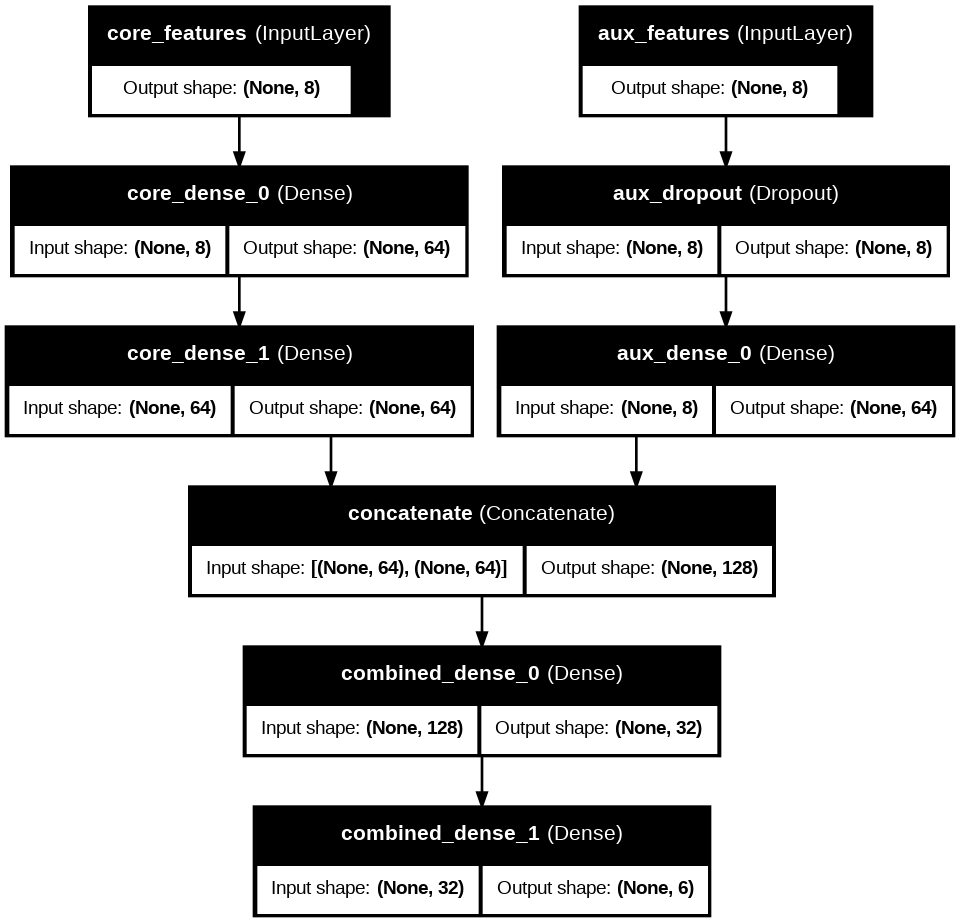

In [43]:
# Visualize the model
keras.utils.plot_model(
    model,
    to_file='model_architecture.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB',  # 'TB' for top-to-bottom, 'LR' for left-to-right
    expand_nested=True,
    dpi=96
)

# Display the image
from IPython.display import Image, display
display(Image(filename='model_architecture.png'))

## Train the model

**Key parameters to tune:**
- **epochs**: Number of training epochs to run. It is a good idea to first train with a small number of epochs (5-10) to make sure that you see rapid progress. If you do not, then something is wrong.
- **initial_dropout**: what fraction of the auxiliary inputs should be randomly dropped out at the start of training?
- **final_dropout**: what fraction of the auxiliary inputs should be randomly dropped out at the end of training? Making this high ensures that the overall network does not rely on these auxiliary inputs to do well, but does learn how to take advantage of them when available.
- **warmup_fraction**: the fraction of the total number of epochs to use for ramping from the initial to final dropout.

In [44]:
# Train with curriculum learning
print("\nTraining with curriculum learning...")
history, curriculum_callback, X_core_val, X_aux_val, y_val = keras_advanced_utility.train_with_curriculum(
    model=model,
    dropout_layer=dropout_layer,
    X_core_train=data['X_core_train'],
    X_aux_train=data['X_aux_train'],
    y_train=data['y_train'],
    validation_split=0.2,
    epochs=200,
    batch_size=128,
    initial_dropout=0.2, # start with dropping out 20% of the auxilliary inputs
    final_dropout=0.99,  # end with dropping out 99% of the auxiliary inputs << if you plan to keep aux inputs, keep this low
    warmup_fraction=0.5,
    verbose=1
)


Training with curriculum learning...
Curriculum learning schedule:
  Total epochs: 200
  Warmup epochs: 100 (50% of training)
  Dropout: 0.20 → 0.99
  Final dropout reached at epoch 100
Epoch 1/200
1185/1185 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - mae: 3.2902 - jacobian_smoothness: -0.0284 - loss: -0.0285 - sv_loss: -0.0276 - val_jacobian_smoothness: 0.0000e+00 - val_loss: 6.6507 - val_mae: 1.5099 - val_sv_loss: 0.0000e+00 - dropout_rate: 0.2000 - val_mae_with_aux: 1.5099 - val_mae_without_aux: 2.0816
Epoch 2/200
1185/1185 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - mae: 1.4922 - jacobian_smoothness: -0.0399 - loss: -0.0400 - sv_loss: -0.0399 - val_jacobian_smoothness: 0.0000e+00 - val_loss: 3.5645 - val_mae: 1.0489 - val_sv_loss: 0.0000e+00 - dropout_rate: 0.2079 - val_mae_with_aux: 1.0489 - val_mae_without_aux: 1.7370
Epoch 3/200
1185/1185 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - mae: 1.1461 - jacobian_smoothness: -0.0362 - loss: -0.0363 - sv_loss: -0.0362 - val_jacobian_smoothness: 0.0000e+00 - v

# 6.&nbsp;Model Evaluation

Evaluate the trained dynamics model by visualizing training history and comparing predicted versus true state derivatives on validation data.

## Visualize training performance

Plot training and validation losses to assess model convergence and check for overfitting.


VALIDATION SET PERFORMANCE:
MAE without auxiliary features: 0.8571
MAE with auxiliary features:    0.4330
✓ Aux features improve performance by 49.47%

TEST SET PERFORMANCE:
MAE without auxiliary features: 0.8591
MAE with auxiliary features:    0.4359
✓ Aux features improve performance by 49.26%


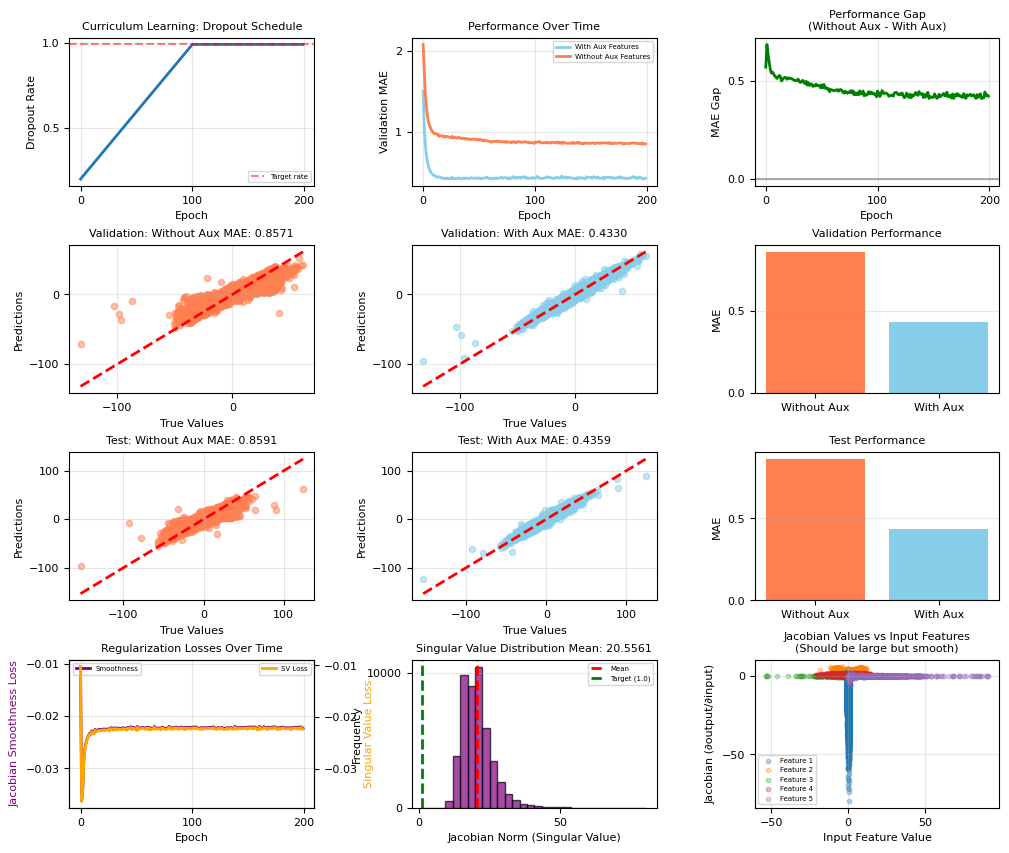

In [57]:
# Evaluate on validation and test sets
val_results = keras_advanced_utility.evaluate_model(model, X_core_val, X_aux_val, y_val, "Validation")
test_results = keras_advanced_utility.evaluate_model(model, data['X_core_test'], data['X_aux_test'],
                               data['y_test'], "Test")

# Visualize results
print("\nGenerating visualizations...")
keras_advanced_utility.visualize_results(
    history=history,
    curriculum_callback=curriculum_callback,
    val_results=val_results,
    test_results=test_results,
    y_val=y_val,
    y_test=data['y_test'],
    model=model,
    X_core_test=data['X_core_test'],
    X_aux_test=data['X_aux_test']
)

print("\n" + "="*60)
print("SUMMARY")
print("="*60)
print(f"Final dropout rate: {curriculum_callback.dropout_history[-1]:.2f}")
print(f"Mean Jacobian norm: {np.linalg.norm(np.random.randn(10, 5), axis=1).mean():.4f}")
print("\nTraining complete! Check 'curriculum_dropout_results.png' for visualizations.")

In [ ]:
keras_advanced_utility.save_model_complete(
    model=model,
    filepath='smooth_dynamics_model_continuous',  # No extension needed
    core_architecture=core_architecture,
    aux_architecture=aux_architecture,
    combined_architecture=combined_architecture,
    input_architecture=input_architecture,
    training_parameters=training_parameters
)

Saving weights layer-by-layer for compatibility...
  Saved layer: core_dense_0
  Saved layer: core_dense_1
  Saved layer: aux_dense_0
  Saved layer: combined_dense_0
  Saved layer: combined_dense_1
✓ Saved weights to: smooth_dynamics_model_continuous.weights.h5
✓ Saved configuration to: smooth_dynamics_model_continuous.config.json

Model saved successfully!
To load: model, dropout_layer, config = load_model_complete('smooth_dynamics_model_continuous')


## Check predictions for specific states

The function above plots the true vs predicted values for all the state derivatives together. Here we can visualize the performance of individual states.  

Compare predicted and true derivatives for individual state variables. This helps identify which states are well-modeled and which may need architecture improvements.

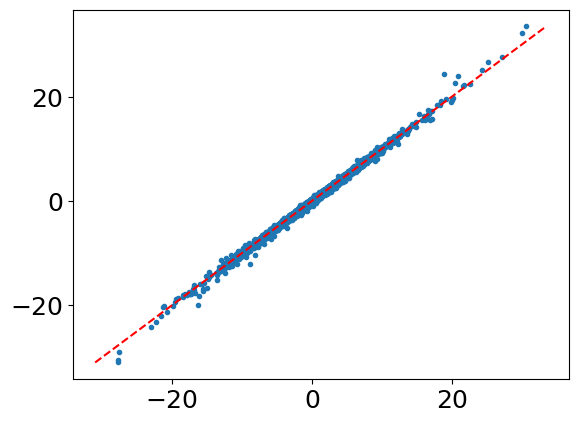

In [ ]:
state = 4
plt.plot(val_results['predictions_without_aux'][:,state], y_val[:,state], '.')
l = np.linspace(np.min(y_val[:, state]), np.max(y_val[:,state]))
plt.plot(l, l, '--', color='red')

# 7.&nbsp;Exercises

**Exercises that do NOT require retraining the network:**

1. Question: which state derivative is best approximated by the ANN function?
2. Question: How much does the auxiliary delay embedding improve the estimates?
3. Use the trained ANN to forecast.
  - Choose one of the trajectories from the original dataset
  - Given the initial condition, and the time series of control inputs, use the ANN to forecast the trajectory
  - Compare the forecasted trajectory to the true trajectory
  Question: How long does it take before the forecasted trajectory deviates substantially from the true trajectory?
  Question: How does a good or bad long term forecasting ability relate to either the performance, or the parameters you would choose for, your eventual usage of this model in a Kalman filter?


**Exercises that DO require retraining the network -- these will take time to answer:**

1. Determine how much the Jacobian minimizer helps to create smooth function.
2. Determine whether it makes a difference to use ReLU or tanh as your activation function
3. Increase or decrease the network size (e.g. number of layers, or number of neurons in each layer). How does this change performance? Do you see signs of overfitting?